In [1]:
import torch
from torch import nn
from torch.optim import Adam
from deap import base, creator, tools, algorithms
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from math import sqrt
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [2]:
data_weather_encoded = pd.read_csv('data_weather_encoded.csv')

data_weather_encoded_lagged= pd.read_csv('data_weather_encoded_lagged.csv')

##### Data preparation

In [3]:
df = data_weather_encoded.dropna()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Extract the data of 'mean_temp'
temp = df['mean_temp'].values.reshape(-1, 1)

# Create a scaler for 'mean_temp' and normalize
temp_scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_temp = temp_scaler.fit_transform(temp)

# data standardization
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# Replace the normalized 'mean_temp' data
scaled_data[:, df.columns.get_loc('mean_temp')] = scaled_temp.ravel()

# Converting Time Series to Supervised Learning Problems
def create_dataset(dataset, look_back=20):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, df.columns.get_loc('mean_temp')])

    return np.array(dataX), np.array(dataY)

look_back = 20
X, y = create_dataset(scaled_data, look_back)

# The division of training set, validation set and test set
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)
test_size = len(X) - train_size - val_size
X_train, X_val, X_test = X[0:train_size,:], X[train_size:(train_size+val_size),:], X[(train_size+val_size):len(X),:]
y_train, y_val, y_test = y[0:train_size], y[train_size:(train_size+val_size)], y[(train_size+val_size):len(y)]

# Data dimension adjustment
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], X_val.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))



In [ ]:
# import the necessary libraries
from bayes_opt import BayesianOptimization
import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
from torch.nn import functional as F
from sklearn.preprocessing import MinMaxScaler

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# create dataset function
def create_dataset(dataset, look_back=look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, df.columns.get_loc('mean_temp')])
    return np.array(dataX), np.array(dataY)

# define model
class ResidualBiLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(ResidualBiLSTM, self).__init__()

        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.bilstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(2*hidden_dim, input_dim) # Make the output of the fully connected layer match the dimensions of the original input
        self.fc_out = nn.Linear(input_dim, output_dim) # output layer

    def forward(self, x):
        h0 = torch.zeros(self.layer_dim*2, x.size(0), self.hidden_dim).to(device) 
        c0 = torch.zeros(self.layer_dim*2, x.size(0), self.hidden_dim).to(device)

        out, (hn, cn) = self.bilstm(x, (h0, c0))
        
        out = F.relu(self.fc(out[:, -1, :]))
        out = self.fc_out(out + x[:, -1, :]) 

        return out

# training model function
def model_training(look_back):
    input_dim = 16
    hidden_dim = 64
    layer_dim = 2
    output_dim = 1
    learning_rate=0.05
    look_back = int(look_back)
    
    model = ResidualBiLSTM(input_dim, hidden_dim, layer_dim, output_dim)
    model = model.to(device)
    
    criterion = nn.MSELoss(reduction='mean')
    optimizer = Adam(model.parameters(), lr=learning_rate)

    # Data preparation 
    X, y = create_dataset(scaled_data, look_back)

    train_size = int(len(X) * 0.7)
    val_size = int(len(X) * 0.15)
    test_size = len(X) - train_size - val_size
    X_train, X_val, X_test = X[0:train_size,:], X[train_size:(train_size+val_size),:], X[(train_size+val_size):len(X),:]
    y_train, y_val, y_test = y[0:train_size], y[train_size:(train_size+val_size)], y[(train_size+val_size):len(y)]
    
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
    X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], X_val.shape[2]))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))
    
    train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
    train_loader = DataLoader(dataset=train_data, batch_size=32, shuffle=True)
    
    # Training Loop
    epochs=20
    for epoch in range(epochs):
        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device).float()
            labels = labels.to(device).float()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    return -loss.item() # Minus is used because Bayesian Optimization finds the maximum

# Instantiate a BayesianOptimization object
pbounds = {'look_back': (1, 30)}

optimizer = BayesianOptimization(
    f=model_training,
    pbounds=pbounds,
    verbose=2,
    random_state=1,
)

# 开始优化
optimizer.maximize(
    init_points=2,
    n_iter=10,
)


In [6]:
best_look_back = optimizer.max['params']['look_back']
print("Best look_back: ", best_look_back)


Best look_back:  13.30463696934594


#### ResidualBiLSTM

In [6]:
class ResidualBiLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(ResidualBiLSTM, self).__init__()

        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.bilstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(2*hidden_dim, input_dim) 
        self.fc_out = nn.Linear(input_dim, output_dim) 
    def forward(self, x):
        h0 = torch.zeros(self.layer_dim*2, x.size(0), self.hidden_dim).to(device) 
        c0 = torch.zeros(self.layer_dim*2, x.size(0), self.hidden_dim).to(device)

        out, (hn, cn) = self.bilstm(x, (h0, c0))
        
        out = F.relu(self.fc(out[:, -1, :]))
        out = self.fc_out(out + x[:, -1, :]) 

        return out
input_dim = X_train.shape[2]
hidden_dim = 64
layer_dim = 2
output_dim = 1
learning_rate=0.05
model = ResidualBiLSTM(input_dim, hidden_dim, layer_dim, output_dim)
model = model.to(device)

# Loss function and optimizer
criterion = nn.MSELoss(reduction='mean')
optimizer = Adam(model.parameters(), lr=learning_rate)

# Create DataLoaders
train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
val_data = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

batch_size = 64
train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size, drop_last=True)
val_loader = DataLoader(val_data, shuffle=False, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_data, shuffle=False, batch_size=1)

# training model
epochs =200
for epoch in range(epochs):
    for i, (x, y) in enumerate(train_loader):
        model.train()
        x = x.to(device).float()
        y = y.to(device).float()
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y.unsqueeze(1))
        loss.backward()
        optimizer.step()
        
    if epoch % 10 == 0:
        model.eval()
        with torch.no_grad():
            val_loss = 0
            for i, (x, y) in enumerate(val_loader):
                x = x.to(device).float()
                y = y.to(device).float()
                outputs = model(x)
                val_loss += criterion(outputs, y.unsqueeze(1))
            print(f'Epoch: {epoch}, Loss: {loss.item()}, Validation Loss: {val_loss / len(val_loader)}')

# Test the model and calculate metrics
model.eval()
with torch.no_grad():
    test_predictions = []
    test_targets = []
    for i, (x, y) in enumerate(test_loader):
        x = x.to(device).float()
        y = y.to(device).float()
        outputs = model(x)
        test_predictions.append(outputs.item())
        test_targets.append(y.item())

# Denormalization
test_predictions = temp_scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1))
test_targets = temp_scaler.inverse_transform(np.array(test_targets).reshape(-1, 1))


# MSE
mse = mean_squared_error(test_targets, test_predictions)

# MAE
mae = mean_absolute_error(test_targets, test_predictions)

# RMSE
rmse = np.sqrt(mse)

# R^2
r2 = r2_score(test_targets, test_predictions)

print(f'Test MSE: {mse}, MAE: {mae}, RMSE: {rmse}, R^2 Score: {r2}')

Epoch: 0, Loss: 0.01100563071668148, Validation Loss: 0.008530358783900738
Epoch: 10, Loss: 0.008981281891465187, Validation Loss: 0.00826600007712841
Epoch: 20, Loss: 0.014550511725246906, Validation Loss: 0.004616301506757736
Epoch: 30, Loss: 0.016188323497772217, Validation Loss: 0.0060506900772452354
Epoch: 40, Loss: 0.01210208423435688, Validation Loss: 0.010647906921803951
Epoch: 50, Loss: 0.011044681072235107, Validation Loss: 0.008879967965185642
Epoch: 60, Loss: 0.013862041756510735, Validation Loss: 0.011634851805865765
Epoch: 70, Loss: 0.010755166411399841, Validation Loss: 0.006378476973623037
Epoch: 80, Loss: 0.029823197051882744, Validation Loss: 0.04654987156391144
Epoch: 90, Loss: 0.009092744439840317, Validation Loss: 0.0045830379240214825
Epoch: 100, Loss: 0.010816453956067562, Validation Loss: 0.006513896398246288
Epoch: 110, Loss: 0.03339185565710068, Validation Loss: 0.05639631301164627
Epoch: 120, Loss: 0.008730761706829071, Validation Loss: 0.004686582833528519
E

#### BiLSTM

In [12]:
class BiLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(BiLSTM, self).__init__()

        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.bilstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True, bidirectional=True,proj_size=0)
        self.fc = nn.Linear(2*hidden_dim, output_dim) 

    def forward(self, x):
        h0 = torch.zeros(self.layer_dim*2, x.size(0), self.hidden_dim).to(device) 
        c0 = torch.zeros(self.layer_dim*2, x.size(0), self.hidden_dim).to(device)

        out, (hn, cn) = self.bilstm(x, (h0, c0))
        
        out = self.fc(out[:, -1, :])
        
        return out

input_dim = X_train.shape[2]
hidden_dim = 64
layer_dim = 2
output_dim = 1
learning_rate=0.05
model = BiLSTM(input_dim, hidden_dim, layer_dim, output_dim)
model = model.to(device)

# Loss function and optimizer
criterion = nn.MSELoss(reduction='mean')
optimizer = Adam(model.parameters(), lr=learning_rate)

# create DataLoaders
train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
val_data = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

batch_size = 64
train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size, drop_last=True)
val_loader = DataLoader(val_data, shuffle=False, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_data, shuffle=False, batch_size=1)

# training model
epochs =200
for epoch in range(epochs):
    for i, (x, y) in enumerate(train_loader):
        model.train()
        x = x.to(device).float()
        y = y.to(device).float()
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y.unsqueeze(1))
        loss.backward()
        optimizer.step()
        
    if epoch % 10 == 0:
        model.eval()
        with torch.no_grad():
            val_loss = 0
            for i, (x, y) in enumerate(val_loader):
                x = x.to(device).float()
                y = y.to(device).float()
                outputs = model(x)
                val_loss += criterion(outputs, y.unsqueeze(1))
            print(f'Epoch: {epoch}, Loss: {loss.item()}, Validation Loss: {val_loss / len(val_loader)}')

# Test the model and calculate metrics
model.eval()
with torch.no_grad():
    test_predictions = []
    test_targets = []
    for i, (x, y) in enumerate(test_loader):
        x = x.to(device).float()
        y = y.to(device).float()
        outputs = model(x)
        test_predictions.append(outputs.item())
        test_targets.append(y.item())


test_predictions = temp_scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1))
test_targets = temp_scaler.inverse_transform(np.array(test_targets).reshape(-1, 1))


# MSE
mse = mean_squared_error(test_targets, test_predictions)

# MAE
mae = mean_absolute_error(test_targets, test_predictions)

# RMSE
rmse = np.sqrt(mse)

# R^2
r2 = r2_score(test_targets, test_predictions)

print(f'Test MSE: {mse}, MAE: {mae}, RMSE: {rmse}, R^2 Score: {r2}')


Epoch: 0, Loss: 0.014757681638002396, Validation Loss: 0.016292961314320564
Epoch: 10, Loss: 0.014262400567531586, Validation Loss: 0.014467763714492321
Epoch: 20, Loss: 0.011192708276212215, Validation Loss: 0.015947703272104263
Epoch: 30, Loss: 0.017590569332242012, Validation Loss: 0.025926224887371063
Epoch: 40, Loss: 0.010520401410758495, Validation Loss: 0.0068075587041676044
Epoch: 50, Loss: 0.010114338248968124, Validation Loss: 0.019208217039704323
Epoch: 60, Loss: 0.010782714933156967, Validation Loss: 0.010814927518367767
Epoch: 70, Loss: 0.0215727798640728, Validation Loss: 0.022856663912534714
Epoch: 80, Loss: 0.02960987761616707, Validation Loss: 0.0500485897064209
Epoch: 90, Loss: 0.008223190903663635, Validation Loss: 0.007360305171459913
Epoch: 100, Loss: 0.007807684130966663, Validation Loss: 0.005312166642397642
Epoch: 110, Loss: 0.023617472499608994, Validation Loss: 0.02178235538303852
Epoch: 120, Loss: 0.02561405673623085, Validation Loss: 0.037185829132795334
Epo

#### 贝叶斯超参数优化

In [13]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

# 1. Define the objective function
def objective(params):
    model = ResidualBiLSTM(int(params['input_dim']), 
                           int(params['hidden_dim']),
                           int(params['layer_dim']),
                           int(params['output_dim']))
    model = model.to(device)

    criterion = nn.MSELoss(reduction='mean')
    optimizer = Adam(model.parameters(), lr=params['learning_rate'])
    
    
    for epoch in range(100):  
        for i, (x, y) in enumerate(train_loader):
            model.train()
            x = x.to(device).float()
            y = y.to(device).float()
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y.unsqueeze(1))
            loss.backward()
            optimizer.step()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for i, (x, y) in enumerate(val_loader):
            x = x.to(device).float()
            y = y.to(device).float()
            outputs = model(x)
            val_loss += criterion(outputs, y.unsqueeze(1)).item()
    
    return {'loss': val_loss / len(val_loader), 'status': STATUS_OK}

# 2. Space to define hyperparameters
space = {
    'input_dim': hp.choice('input_dim', [X_train.shape[2]]), # Assuming X_train is globally accessible
    'hidden_dim': hp.choice('hidden_dim', [32, 64, 128,256]),
    'layer_dim': hp.choice('layer_dim', [1, 2, 3]),
    'output_dim': hp.choice('output_dim', [1]), # Assuming output_dim is 1, adjust as necessary
    'learning_rate': hp.loguniform('learning_rate', np.log(0.001), np.log(1))
}

# 3. Choose a search algorithm
tpe_algorithm = tpe.suggest

# 4. optimize
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe_algorithm,
            max_evals=50,  # Number of evaluations, adjust as necessary
            trials=trials)

print(best)



100%|██████████| 50/50 [1:12:52<00:00, 87.44s/trial, best loss: 0.003609198285266757] 
{'hidden_dim': 0, 'input_dim': 0, 'layer_dim': 1, 'learning_rate': 0.017906789494353384, 'output_dim': 0}


In [ ]:
{'hidden_dim': 256, 'input_dim': 0, 'layer_dim': 3, 'learning_rate': 0.007584362648675078, 'output_dim': 1}

#### 遗传算法超参数优化


In [60]:
import numpy as np
from deap import base, creator, tools, algorithms
import torch
from torch.optim import Adam


# Define evaluation function (our objective to minimize)
def evalLSTM(params):
    input_dim, hidden_dim, layer_dim, output_dim, learning_rate = params
    
    model = ResidualBiLSTM(input_dim, hidden_dim, layer_dim, output_dim)
    model = model.to(device)

    criterion = nn.MSELoss(reduction='mean')
    optimizer = Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(10):
        for i, (x, y) in enumerate(train_loader):
            model.train()
            x = x.to(device).float()
            y = y.to(device).float()
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y.unsqueeze(1))
            loss.backward()
            optimizer.step()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for i, (x, y) in enumerate(val_loader):
            x = x.to(device).float()
            y = y.to(device).float()
            outputs = model(x)
            val_loss += criterion(outputs, y.unsqueeze(1)).item()

    return val_loss / len(val_loader),

# Mutation function
def mutateAndClipLSTM(individual, indpb):
    # Apply Gaussian mutation
    tools.mutGaussian(individual, mu=0, sigma=0.2, indpb=indpb)

    # Clip the values
    individual[0] = X_train.shape[2]         # input_dim
    individual[1] = max(256, int(individual[1])) # hidden_dim
    individual[2] = max(3, int(individual[2]))  # layer_dim
    individual[3] = 1                          # output_dim
    individual[4] = max(0.001, individual[4])  # learning_rate
    
    return individual,

# Genetic Algorithm setup
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("input_dim", np.random.choice, [X_train.shape[2]])
toolbox.register("hidden_dim", np.random.choice, [32, 64, 128, 256])
toolbox.register("layer_dim", np.random.choice, [1, 2, 3])
toolbox.register("output_dim", np.random.choice, [1])
toolbox.register("learning_rate", np.random.uniform, 0.001, 1)

toolbox.register("individual", tools.initCycle, creator.Individual, 
                 (toolbox.input_dim, toolbox.hidden_dim, toolbox.layer_dim, toolbox.output_dim, toolbox.learning_rate), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", mutateAndClipLSTM, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evalLSTM)

# Genetic Algorithm execution
population_size = 50
crossover_probability = 0.5
mutation_probability = 0.2
number_of_generations = 30

pop = toolbox.population(n=population_size)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("max", np.max)

algorithms.eaSimple(pop, toolbox, crossover_probability, mutation_probability, number_of_generations, stats, halloffame=hof)

# Print the best individual
print(hof[0])





D:\Anaconda3\envs\deep_learning\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
D:\Anaconda3\envs\deep_learning\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
D:\Anaconda3\envs\deep_learning\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([64, 1, 14])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


gen	nevals	avg     	min      	max    
0  	50    	0.565162	0.0433726	9.21749
1  	34    	0.286486	0.0432505	3.64282
2  	39    	0.0843283	0.0419331	0.751851
3  	29    	0.0540723	0.043191 	0.215127
4  	44    	0.0552231	0.0409447	0.389719
5  	37    	0.0503379	0.0420462	0.161529
6  	39    	0.0458401	0.0395925	0.0655682
7  	38    	0.0461379	0.038915 	0.152581 
8  	37    	0.0435341	0.038915 	0.0474701
9  	38    	0.0430538	0.038915 	0.048838 
10 	37    	0.0420468	0.0386037	0.0481679
[13, 256, 3, 1, 0.004124870068398859]


In [ ]:
[13, 256, 3, 1, 0.004124870068398859]

##### 使用最佳参数预测-贝叶斯优化最佳参数

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
class ResidualBiLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(ResidualBiLSTM, self).__init__()

        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.bilstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(2*hidden_dim, input_dim) 
        self.fc_out = nn.Linear(input_dim, output_dim) 

    def forward(self, x):
        h0 = torch.zeros(self.layer_dim*2, x.size(0), self.hidden_dim).to(device) 
        c0 = torch.zeros(self.layer_dim*2, x.size(0), self.hidden_dim).to(device)

        out, (hn, cn) = self.bilstm(x, (h0, c0))
        
        out = F.relu(self.fc(out[:, -1, :]))
        out = self.fc_out(out + x[:, -1, :]) 

        return out
input_dim = X_train.shape[2]
hidden_dim = 32
layer_dim = 2
output_dim = 1
learning_rate=0.017906789494353384
model = ResidualBiLSTM(input_dim, hidden_dim, layer_dim, output_dim)
model = model.to(device)

# Loss function and optimizer
criterion = nn.MSELoss(reduction='mean')
optimizer = Adam(model.parameters(), lr=learning_rate)

# create DataLoaders
train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
val_data = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

batch_size = 64
train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size, drop_last=True)
val_loader = DataLoader(val_data, shuffle=False, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_data, shuffle=False, batch_size=1)

# training model
epochs =200
for epoch in range(epochs):
    for i, (x, y) in enumerate(train_loader):
        model.train()
        x = x.to(device).float()
        y = y.to(device).float()
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y.unsqueeze(1))
        loss.backward()
        optimizer.step()
        
    if epoch % 20 == 0:
        model.eval()
        with torch.no_grad():
            val_loss = 0
            for i, (x, y) in enumerate(val_loader):
                x = x.to(device).float()
                y = y.to(device).float()
                outputs = model(x)
                val_loss += criterion(outputs, y.unsqueeze(1))
            print(f'Epoch: {epoch}, Loss: {loss.item()}, Validation Loss: {val_loss / len(val_loader)}')

# Test the model and calculate metrics
model.eval()
with torch.no_grad():
    test_predictions = []
    test_targets = []
    for i, (x, y) in enumerate(test_loader):
        x = x.to(device).float()
        y = y.to(device).float()
        outputs = model(x)
        test_predictions.append(outputs.item())
        test_targets.append(y.item())

# Denormalization
test_predictions = temp_scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1))
test_targets = temp_scaler.inverse_transform(np.array(test_targets).reshape(-1, 1))


# MSE
mse = mean_squared_error(test_targets, test_predictions)

# MAE
mae = mean_absolute_error(test_targets, test_predictions)

# RMSE
rmse = np.sqrt(mse)

# R^2
r2 = r2_score(test_targets, test_predictions)

print(f'Test MSE: {mse}, MAE: {mae}, RMSE: {rmse}, R^2 Score: {r2}')

Epoch: 0, Loss: 0.010421465151011944, Validation Loss: 0.007456405553966761
Epoch: 20, Loss: 0.009033347479999065, Validation Loss: 0.0039042362477630377
Epoch: 40, Loss: 0.009442368522286415, Validation Loss: 0.0041809119284152985
Epoch: 60, Loss: 0.009438769891858101, Validation Loss: 0.004180882126092911
Epoch: 80, Loss: 0.009438915178179741, Validation Loss: 0.00418109679594636
Epoch: 100, Loss: 0.009438935667276382, Validation Loss: 0.004181129392236471
Epoch: 120, Loss: 0.009438937529921532, Validation Loss: 0.004181113559752703
Epoch: 140, Loss: 0.009438937529921532, Validation Loss: 0.004181119613349438
Epoch: 160, Loss: 0.009438933804631233, Validation Loss: 0.004181107506155968
Epoch: 180, Loss: 0.009438937529921532, Validation Loss: 0.004181117285043001
Test MSE: 2.1769520409532017, MAE: 1.0639568126079404, RMSE: 1.4754497758152263, R^2 Score: 0.9303571363013968


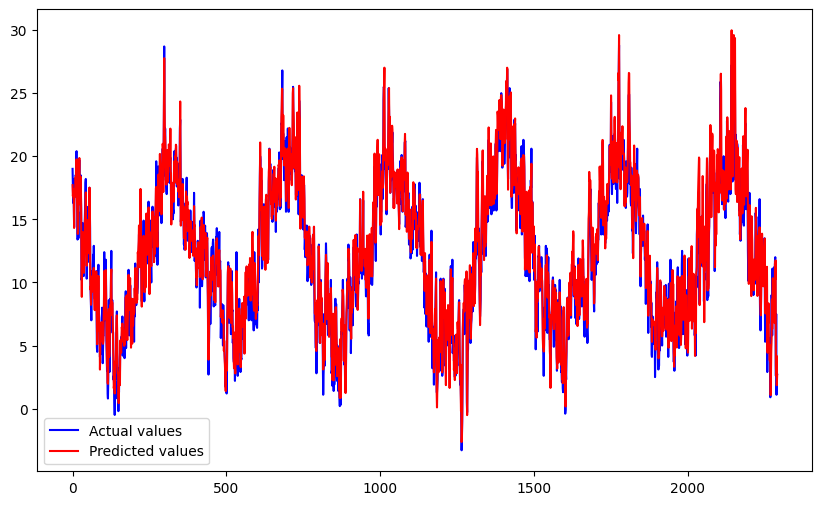

In [15]:
# 绘制预测值和实际值的对比图
plt.figure(figsize=(10,6))
plt.plot(range(len(test_targets)), test_targets, color='blue', label='Actual values')
plt.plot(range(len(test_predictions)), test_predictions, color='red', label='Predicted values')
plt.legend()
plt.show()

#### 使用最佳参数预测-遗传算法最佳参数

In [ ]:
[13, 256, 3, 1, 0.004124870068398859]

In [4]:
class ResidualBiLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(ResidualBiLSTM, self).__init__()

        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.bilstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(2*hidden_dim, input_dim) 
        self.fc_out = nn.Linear(input_dim, output_dim) 

    def forward(self, x):
        h0 = torch.zeros(self.layer_dim*2, x.size(0), self.hidden_dim).to(device) 
        c0 = torch.zeros(self.layer_dim*2, x.size(0), self.hidden_dim).to(device)

        out, (hn, cn) = self.bilstm(x, (h0, c0))
        
        out = F.relu(self.fc(out[:, -1, :]))
        out = self.fc_out(out + x[:, -1, :]) 

        return out
input_dim = X_train.shape[2]
hidden_dim = 256
layer_dim = 3
output_dim = 1
learning_rate=0.004124870068398859
model = ResidualBiLSTM(input_dim, hidden_dim, layer_dim, output_dim)
model = model.to(device)

# Loss function and optimizer
criterion = nn.MSELoss(reduction='mean')
optimizer = Adam(model.parameters(), lr=learning_rate)

# create DataLoaders
train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
val_data = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

batch_size = 64
train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size, drop_last=True)
val_loader = DataLoader(val_data, shuffle=False, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_data, shuffle=False, batch_size=1)

# training model
epochs =200
for epoch in range(epochs):
    for i, (x, y) in enumerate(train_loader):
        model.train()
        x = x.to(device).float()
        y = y.to(device).float()
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y.unsqueeze(1))
        loss.backward()
        optimizer.step()
        
    if epoch % 20 == 0:
        model.eval()
        with torch.no_grad():
            val_loss = 0
            for i, (x, y) in enumerate(val_loader):
                x = x.to(device).float()
                y = y.to(device).float()
                outputs = model(x)
                val_loss += criterion(outputs, y.unsqueeze(1))
            print(f'Epoch: {epoch}, Loss: {loss.item()}, Validation Loss: {val_loss / len(val_loader)}')

# Test the model and calculate metrics
model.eval()
with torch.no_grad():
    test_predictions = []
    test_targets = []
    for i, (x, y) in enumerate(test_loader):
        x = x.to(device).float()
        y = y.to(device).float()
        outputs = model(x)
        test_predictions.append(outputs.item())
        test_targets.append(y.item())

# Denormalization
test_predictions = temp_scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1))
test_targets = temp_scaler.inverse_transform(np.array(test_targets).reshape(-1, 1))


# MSE
mse = mean_squared_error(test_targets, test_predictions)

# MAE
mae = mean_absolute_error(test_targets, test_predictions)

# RMSE
rmse = np.sqrt(mse)

# R^2
r2 = r2_score(test_targets, test_predictions)

print(f'Test MSE: {mse}, MAE: {mae}, RMSE: {rmse}, R^2 Score: {r2}')

Epoch: 0, Loss: 0.012780481949448586, Validation Loss: 0.014646019786596298
Epoch: 20, Loss: 0.009210399352014065, Validation Loss: 0.004718339070677757
Epoch: 40, Loss: 0.003997894003987312, Validation Loss: 0.006718495860695839
Epoch: 60, Loss: 0.0015748962759971619, Validation Loss: 0.01016824971884489
Epoch: 80, Loss: 0.0006987981032580137, Validation Loss: 0.008128122426569462
Epoch: 100, Loss: 0.0005618283757939935, Validation Loss: 0.009346366859972477
Epoch: 120, Loss: 0.0004491885774768889, Validation Loss: 0.008781848475337029
Epoch: 140, Loss: 0.0018483351450413465, Validation Loss: 0.009653217159211636
Epoch: 160, Loss: 0.0014449385926127434, Validation Loss: 0.008695531636476517
Epoch: 180, Loss: 0.0014599954010918736, Validation Loss: 0.012254700995981693
Test MSE: 3.787422581799802, MAE: 1.5112513193168253, RMSE: 1.946130155410938, R^2 Score: 0.878836579919417


#### 探寻不同look_back值对模型的表现影响

In [5]:
def train_and_evaluate(look_back):
    X, y = create_dataset(scaled_data, look_back)
    train_size = int(len(X) * 0.7)
    val_size = int(len(X) * 0.15)
    test_size = len(X) - train_size - val_size
    X_train, X_val, X_test = X[0:train_size,:], X[train_size:(train_size+val_size),:], X[(train_size+val_size):len(X),:]
    y_train, y_val, y_test = y[0:train_size], y[train_size:(train_size+val_size)], y[(train_size+val_size):len(y)]
    model = ResidualBiLSTM(input_dim, hidden_dim, layer_dim, output_dim).to(device)
    optimizer = Adam(model.parameters(), lr=learning_rate)
    train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
    val_data = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))
    test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
    train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size, drop_last=True)
    val_loader = DataLoader(val_data, shuffle=False, batch_size=batch_size, drop_last=True)
    test_loader = DataLoader(test_data, shuffle=False, batch_size=1)

    for epoch in range(epochs):
        for i, (x, y) in enumerate(train_loader):
            model.train()
            x, y = x.to(device).float(), y.to(device).float()
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y.unsqueeze(1))
            loss.backward()
            optimizer.step()

        if epoch % 20 == 0:
            model.eval()
            with torch.no_grad():
                val_loss = 0
                for i, (x, y) in enumerate(val_loader):
                    x, y = x.to(device).float(), y.to(device).float()
                    outputs = model(x)
                    val_loss += criterion(outputs, y.unsqueeze(1))
                print(f'Epoch: {epoch}, Loss: {loss.item()}, Validation Loss: {val_loss / len(val_loader)}')

    model.eval()
    test_predictions, test_targets = [], []
    with torch.no_grad():
        for i, (x, y) in enumerate(test_loader):
            x, y = x.to(device).float(), y.to(device).float()
            outputs = model(x)
            test_predictions.append(outputs.item())
            test_targets.append(y.item())

    test_predictions = temp_scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1))
    test_targets = temp_scaler.inverse_transform(np.array(test_targets).reshape(-1, 1))
    mse = mean_squared_error(test_targets, test_predictions)
    mae = mean_absolute_error(test_targets, test_predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(test_targets, test_predictions)

    return mse, mae, rmse, r2

look_back_values = [20, 30, 40, 50]
for look_back in look_back_values:
    print(f"===== Evaluating for look_back = {look_back} =====")
    mse, mae, rmse, r2 = train_and_evaluate(look_back)
    print(f'Test MSE: {mse}, MAE: {mae}, RMSE: {rmse}, R^2 Score: {r2}')

===== Evaluating for look_back = 20 =====
Epoch: 0, Loss: 0.05561219900846481, Validation Loss: 0.06643274426460266
Epoch: 20, Loss: 0.009088829159736633, Validation Loss: 0.0047268676571547985
Epoch: 40, Loss: 0.008713084273040295, Validation Loss: 0.004162074998021126
Epoch: 60, Loss: 0.008728774264454842, Validation Loss: 0.004188428167253733
Epoch: 80, Loss: 0.008728835731744766, Validation Loss: 0.004231822676956654
Epoch: 100, Loss: 0.008730502799153328, Validation Loss: 0.0042505525052547455
Epoch: 120, Loss: 0.00873146578669548, Validation Loss: 0.004258271306753159
Epoch: 140, Loss: 0.0087319016456604, Validation Loss: 0.004261436872184277
Epoch: 160, Loss: 0.008732088841497898, Validation Loss: 0.004262725822627544
Epoch: 180, Loss: 0.008732164278626442, Validation Loss: 0.004263251554220915
Test MSE: 2.114239170882488, MAE: 1.039882644741791, RMSE: 1.4540423552574004, R^2 Score: 0.9323633834673062
===== Evaluating for look_back = 30 =====
Epoch: 0, Loss: 0.012781653553247452

#### 不同期限的预测精度，1天，3天，7天和14天

In [5]:
df = data_weather_encoded


temp = df['mean_temp'].values.reshape(-1, 1)

# Create a scaler for 'mean_temp' and normalize
temp_scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_temp = temp_scaler.fit_transform(temp)

# data standardization
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# Replace the normalized 'mean_temp' data
scaled_data[:, df.columns.get_loc('mean_temp')] = scaled_temp.ravel()

def create_sequences(data, look_back, future_days=1):
    xs, ys = [], []
    for i in range(len(data) - look_back - future_days + 1):
        x = data[i:(i+look_back)]
        y = data[i+look_back:i+look_back+future_days, df.columns.get_loc('mean_temp')]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

look_back = 20
future_days_list = [1, 3, 7, 14]

for future_days in future_days_list:
    X, y = create_sequences(scaled_data, look_back, future_days)

  
    train_size = int(len(X) * 0.7)
    val_size = int(len(X) * 0.15)
    test_size = len(X) - train_size - val_size
    X_train, X_val, X_test = X[0:train_size,:], X[train_size:(train_size+val_size),:], X[(train_size+val_size):len(X),:]
    y_train, y_val, y_test = y[0:train_size], y[train_size:(train_size+val_size)], y[(train_size+val_size):len(y)]



In [6]:
input_dim = X_train.shape[2]
hidden_dim = 32
layer_dim = 2
output_dim = 1
learning_rate=0.017906789494353384
class ResidualBiLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(ResidualBiLSTM, self).__init__()

        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        self.bilstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(2*hidden_dim, input_dim) 
        self.fc_out = nn.Linear(input_dim, output_dim)  # The output layer can now be dynamically adjusted according to the number of days required

    def forward(self, x):
        h0 = torch.zeros(self.layer_dim*2, x.size(0), self.hidden_dim).to(device) 
        c0 = torch.zeros(self.layer_dim*2, x.size(0), self.hidden_dim).to(device)

        out, (hn, cn) = self.bilstm(x, (h0, c0))
        
        out = F.relu(self.fc(out[:, -1, :]))
        out = self.fc_out(out + x[:, -1, :])

        return out


In [7]:
for future_days in future_days_list:
    
    # Splitting code with create_sequences and data 
    X, y = create_sequences(scaled_data, look_back, future_days)
    
    # The division of training set, validation set and test set
    train_size = int(len(X) * 0.7)
    val_size = int(len(X) * 0.15)
    test_size = len(X) - train_size - val_size
    X_train, X_val, X_test = X[0:train_size,:], X[train_size:(train_size+val_size),:], X[(train_size+val_size):len(X),:]
    y_train, y_val, y_test = y[0:train_size], y[train_size:(train_size+val_size)], y[(train_size+val_size):len(y)]

    # Re-instantiate the model based on future_days
    model = ResidualBiLSTM(input_dim, hidden_dim, layer_dim, future_days)
    model = model.to(device)

    # Loss function and optimizer
    criterion = nn.MSELoss(reduction='mean')
    optimizer = Adam(model.parameters(), lr=learning_rate)

    # DataLoader setup
    train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
    val_data = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))
    test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

    train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size, drop_last=True)
    val_loader = DataLoader(val_data, shuffle=False, batch_size=batch_size, drop_last=True)
    test_loader = DataLoader(test_data, shuffle=False, batch_size=1)

    # training model
    for epoch in range(200):
        for i, (x, y) in enumerate(train_loader):
            model.train()
            x = x.to(device).float()
            y = y.to(device).float()
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
        
        if epoch % 20 == 0:
            model.eval()
            with torch.no_grad():
                val_loss = 0
                for i, (x, y) in enumerate(val_loader):
                    x = x.to(device).float()
                    y = y.to(device).float()
                    outputs = model(x)
                    val_loss += criterion(outputs, y)
                print(f'Future days: {future_days}, Epoch: {epoch}, Loss: {loss.item()}, Validation Loss: {val_loss / len(val_loader)}')

    # Test the model and calculate metrics
    model.eval()
    test_predictions = []
    test_targets = []
    with torch.no_grad():
        for i, (x, y) in enumerate(test_loader):
            x = x.to(device).float()
            y = y.to(device).float()
            outputs = model(x)
            test_predictions.append(outputs.cpu().numpy())
            test_targets.append(y.cpu().numpy())

    # Denormalization
    test_predictions = temp_scaler.inverse_transform(np.array(test_predictions).reshape(-1, future_days))
    test_targets = temp_scaler.inverse_transform(np.array(test_targets).reshape(-1, future_days))

    # Calculate MSE, MAE, RMSE, R^2
    mse = mean_squared_error(test_targets, test_predictions)
    mae = mean_absolute_error(test_targets, test_predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(test_targets, test_predictions)

    print(f'For {future_days} days prediction -> MSE: {mse}, MAE: {mae}, RMSE: {rmse}, R^2 Score: {r2}')

Future days: 1, Epoch: 0, Loss: 0.010843022726476192, Validation Loss: 0.0081864595413208
Future days: 1, Epoch: 20, Loss: 0.00956089235842228, Validation Loss: 0.004097435623407364
Future days: 1, Epoch: 40, Loss: 0.009440351277589798, Validation Loss: 0.004180781543254852
Future days: 1, Epoch: 60, Loss: 0.009438811801373959, Validation Loss: 0.004180959891527891
Future days: 1, Epoch: 80, Loss: 0.009438924491405487, Validation Loss: 0.004181101452559233
Future days: 1, Epoch: 100, Loss: 0.00943892914801836, Validation Loss: 0.004181126598268747
Future days: 1, Epoch: 120, Loss: 0.00943894125521183, Validation Loss: 0.004181115888059139
Future days: 1, Epoch: 140, Loss: 0.009438932873308659, Validation Loss: 0.00418110890313983
Future days: 1, Epoch: 160, Loss: 0.009438940323889256, Validation Loss: 0.0041811224073171616
Future days: 1, Epoch: 180, Loss: 0.009438939392566681, Validation Loss: 0.0041811345145106316
For 1 days prediction -> MSE: 2.1848435401916504, MAE: 1.0653985738754

#### 输出预测

In [47]:


def predict_future(model, last_data, look_back, future_days, temp_scaler):
    # scaled
    last_data_scaled = scaler.transform(last_data)
    temp_value = last_data_scaled[:, df.columns.get_loc('mean_temp')]
    temp_value = temp_scaler.transform(temp_value.reshape(-1, 1))
    last_data_scaled[:, df.columns.get_loc('mean_temp')] = temp_value.ravel()

    # Use model predictions
    last_data_tensor = torch.tensor(last_data_scaled).unsqueeze(0).to(device).float()
    model.eval()
    with torch.no_grad():
        prediction = model(last_data_tensor)
    
    # Denormalization
    prediction = prediction.cpu().numpy().reshape(-1, future_days)
    prediction = temp_scaler.inverse_transform(prediction)
    return prediction

last_data = df.iloc[-look_back:].values
predictions = {}

for future_days in future_days_list:
    # reload model
    model = ResidualBiLSTM(input_dim, hidden_dim, layer_dim, future_days)
    model = model.to(device)  、

    pred = predict_future(model, last_data, look_back, future_days, temp_scaler)
    predictions[future_days] = pred

# Print/Save Forecast
for days, pred in predictions.items():
    print(f"Prediction for {days} days in the future: {pred}")






Prediction for 1 days in the future: [[19.676584]]
Prediction for 3 days in the future: [[16.61411  18.678875 20.993803]]
Prediction for 7 days in the future: [[10.636948  9.572749 24.352829 15.462659  9.921019  6.869821 17.84437 ]]
Prediction for 14 days in the future: [[ 1.0736841   9.934121    8.242212   12.005588    0.67978156 15.66152
  14.145833   12.414377   12.265707    8.153782   16.550274    5.7892213
   8.934298    8.437331  ]]


D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
D:\Anaconda3\envs\deep_learning\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [48]:

import pickle
with open("lstm_future_predictions.pkl", "wb") as file:
    pickle.dump(predictions, file)